In [7]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from pathlib import Path
# from google.colab import drive

In [8]:
torch.cuda.is_available()

True

In [9]:
# drive.mount('/content/drive')
# path = Path('/content/drive/MyDrive/Colab_Data/Person_Tracking')
path = Path()

In [12]:
images = [str(path) for path in path.glob('Inputs/*.jpg')]
images

['Inputs/IMG_20230210_225957.jpg']

In [13]:
image = Image.open(images[0])

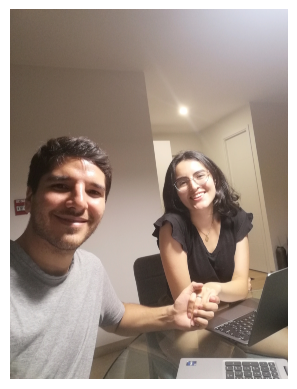

In [14]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_axis_off()
plt.show()

In [15]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Ber

In [16]:
inputs = processor(images=image, return_tensors="pt")

In [17]:
outputs = model(**inputs)

In [18]:
# Returns the original image size: [width, height]
target_sizes = torch.tensor([[image.size[1], image.size[0]]])
target_sizes

tensor([[6528, 4896]])

In [19]:
results = processor.post_process_object_detection(outputs, target_sizes = target_sizes, threshold=0.9)
results

[{'scores': tensor([0.9770, 0.9081, 0.9968, 0.9991, 0.9979], grad_fn=<IndexBackward0>),
  'labels': tensor([62, 76, 73,  1,  1]),
  'boxes': tensor([[2159.8293, 4288.7070, 2858.5315, 5286.9424],
          [3592.9893, 5290.5420, 4416.8750, 5881.0820],
          [3394.3584, 4526.9453, 4892.2935, 6015.8027],
          [  10.7091, 2217.6460, 3721.7073, 6442.7114],
          [2487.8440, 2481.9165, 4295.6128, 5243.3755]],
         grad_fn=<IndexBackward0>)}]

In [20]:
for result in results:
  for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      print(
              f"Detected {model.config.id2label[label.item()]} with confidence "
              f"{round(score.item(), 3)} at location {box}"
      )

Detected chair with confidence 0.977 at location [2159.83, 4288.71, 2858.53, 5286.94]
Detected keyboard with confidence 0.908 at location [3592.99, 5290.54, 4416.88, 5881.08]
Detected laptop with confidence 0.997 at location [3394.36, 4526.95, 4892.29, 6015.8]
Detected person with confidence 0.999 at location [10.71, 2217.65, 3721.71, 6442.71]
Detected person with confidence 0.998 at location [2487.84, 2481.92, 4295.61, 5243.38]


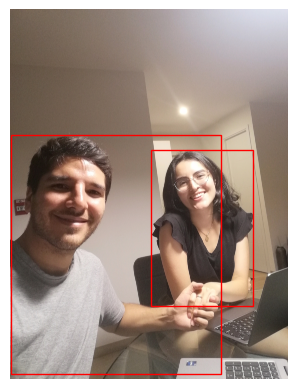

In [21]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_axis_off()
for result in results:
  for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    if model.config.id2label[label.item()] == 'person':
      box = box.tolist()
      box_image = Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(box_image)
plt.show()